In [1]:
### Simulation parameters
n_donors = 2
n_conditions = 3
n_cells_per_donor_cond = 300
n_clones_in_don = 5
n_positions = 100
n_variants_per_clone_lambda = 1
n_donor_variants = 10

seq_error = 0.01
don_var_lim=(0.8,1)
clone_var_lim=(0.1,0.4)
depth_lim = (4,10)
chars = ["A", "G", "C", "T"]

outdir = "/data/Mito_Trace/output/clone_pileups_simulation/samePos/"

ref_fa = "/data/Mito_Trace/data/processed/genomes/mtMasked/GRCh38_MT_blacklist_A2_2020/chrM.fasta"

dirs = "/data/Mito_Trace/output/pipeline/CHIP_b1/MTBlacklist_A2/data/Control/MT/cellr_True/numread_200/"
pileup_outdir = "MT/cellr_True/numread_200/"




In [2]:
from Bio import SeqIO

import pandas as pd
import numpy as np
import seaborn as sns
from os.path import join, exists
import os
import matplotlib.pyplot as plt
np.random.seed(42)
%matplotlib inline
import mplh.cluster_help as ch

from pandarallel import pandarallel
pandarallel.initialize(nb_workers=16)


fig_utils from mplh
INFO: Pandarallel will run on 16 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [3]:
params = {"donors":n_donors,"conditions":n_conditions, "cells_per_donor_cond":n_cells_per_donor_cond,
         "clones_in_don":n_clones_in_don, "positions":n_positions, 
          "variants_per_clone_lambda":n_variants_per_clone_lambda, "donor_variants":n_donor_variants}


seq_params = {"seq_error": seq_error, "don_var_lim":"_".join(np.array(don_var_lim).astype(str)), 
              "clone_var_lim": "_".join(np.array(clone_var_lim).astype(str)),
             "depth_lim":"_".join(np.array(depth_lim).astype(str))}

curr_out_meta = ""
for p in params:
    curr_out_meta = f"{curr_out_meta}__{p}_{params[p]}"

curr_out_meta = curr_out_meta.strip("__")
print(curr_out_meta)


curr_out_seq = ""
for p in seq_params:
    curr_out_seq = f"{curr_out_seq}__{p}_{seq_params[p]}"
curr_out_seq = curr_out_seq.strip("__")
print(curr_out_seq)

samePos_outdir = join(outdir, curr_out_meta, curr_out_seq) #join(pile_in, "samePos")
#samePos_meta_outdir = join(pile_in, "samePos")

donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10
seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10


In [4]:
samePos_outdir

'/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10'

## Load all variables

In [5]:
#ref_char = np.random.choice(chars, n_positions)
ref_char = list(str(SeqIO.to_dict(SeqIO.parse(ref_fa, "fasta"))["chrM"].seq))

ref = [f"{i}_{c}" for i, c in enumerate(ref_char)]

ref_df = pd.DataFrame(np.array([range(len(ref_char)),ref_char]).transpose(),index=ref, columns=["pos", "ref"])
ref_df.head()

,pos,ref
0_G,0,G
1_A,1,A
2_T,2,T
3_C,3,C
4_A,4,A


In [6]:
don_vars_df = pd.read_csv(join(samePos_outdir, "donor_vars.csv"), index_col=0)
clone_vars_df = pd.read_csv(join(samePos_outdir, "clone_vars.csv"), index_col=0)
all_cells_df = pd.read_csv(join(samePos_outdir, "cells_meta.csv"), index_col=0)
clones_meta_cond_df = pd.read_csv(join(samePos_outdir, "clones_meta.csv"), index_col=0)

In [7]:
clones_meta_cond_df.head()

,clone,condition,donor,ncells
0,d0cl1,0,0,46
1,d0cl1,1,0,65
2,d0cl1,2,0,63
3,d0cl2,0,0,63
4,d0cl2,1,0,44


### Generate cells with donor and clone assignment

In [8]:
donors = all_cells_df["donor"].unique()
conditions = all_cells_df["condition"].unique()
conditions

array([0, 1, 2])

### Generate clone meta with ncells, do for condition and groupby it

In [9]:
# Make clones_meta_cond_df and clones_meta_df
clones_meta_cond_df = all_cells_df.groupby(["clone", "condition", "donor"]).size().to_frame('ncells').reset_index()
clones_meta_cond_df

,clone,condition,donor,ncells
0,d0cl1,0,0,46
1,d0cl1,1,0,65
2,d0cl1,2,0,63
3,d0cl2,0,0,63
4,d0cl2,1,0,44
5,d0cl2,2,0,59
6,d1cl0,0,1,63
7,d1cl0,1,1,61
8,d1cl0,2,1,59
9,d1cl1,0,1,59


In [10]:
clones_meta_df = clones_meta_cond_df.groupby(["clone", "donor"]).sum()["ncells"].to_frame("ncells").reset_index()
clones_meta_df

,clone,donor,ncells
0,d0cl1,0,174
1,d0cl2,0,166
2,d1cl0,1,183
3,d1cl1,1,178
4,d1cl2,1,181
5,d1cl3,1,171
6,d1cl4,1,187


In [13]:
## Convert to nt's
all_nt_pileup = {}
all_coverage = {}
for cond in conditions: #curr_out_df in pileups_df_strand.groupby(["nt", "condition"]):
    for nt in chars:
        cond_outdir = join(samePos_outdir, "data", f"cond{cond}", pileup_outdir)
        print(cond_outdir)
        print(nt,cond)
        
        all_nt_pileup[(cond, nt)] = pd.read_csv(join(cond_outdir, f"cond{cond}.{nt}.strands.txt"), 
                                             header=None)
    all_coverage[cond] = pd.read_csv(join(cond_outdir, f"cond{cond}.coverage.strands.txt"), 
                                 header=None)
    #curr_out.to_csv(join(outdir, f"cond_{cond}.{nt}.strands.txt.gz"), compression='gzip')

/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/cond0/MT/cellr_True/numread_200/
A 0
/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/cond0/MT/cellr_True/numread_200/
G 0
/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_donor_cond_300__clones_in_don_5__positions_100__variants_per_clone_lambda_1__donor_variants_10/seq_error_0.01__don_var_lim_0.8_1.0__clone_var_lim_0.1_0.4__depth_lim_4_10/data/cond0/MT/cellr_True/numread_200/
C 0
/data/Mito_Trace/output/clone_pileups_simulation/samePos/donors_2__conditions_3__cells_per_

In [14]:
all_coverage_df = pd.concat(all_coverage).reset_index(drop=True).pivot(index=1,columns=0, values=2)
all_coverage_df

,1,2,3,4,5,6,7,8,9,10,...,16560,16561,16562,16563,16564,16565,16566,16567,16568,16569
1,,,,,,,,,,,,,,,,,,,,,
Cell0donor0condition0cloned0cl3,8.0,512.0,32.0,64.0,16.0,32.0,16.0,8.0,256.0,256.0,...,16.0,32.0,512.0,256.0,8.0,256.0,4.0,64.0,512.0,16.0
Cell0donor0condition1cloned0cl4,4.0,4.0,16.0,32.0,128.0,512.0,256.0,8.0,16.0,16.0,...,32.0,4.0,128.0,4.0,16.0,512.0,64.0,4.0,4.0,128.0
Cell0donor0condition2cloned0cl2,4.0,128.0,16.0,256.0,128.0,64.0,4.0,128.0,256.0,64.0,...,256.0,64.0,64.0,4.0,256.0,64.0,128.0,4.0,256.0,8.0
Cell0donor1condition0cloned1cl2,256.0,16.0,128.0,8.0,512.0,64.0,4.0,64.0,16.0,64.0,...,16.0,128.0,32.0,16.0,256.0,8.0,128.0,64.0,8.0,16.0
Cell0donor1condition1cloned1cl1,64.0,32.0,4.0,16.0,4.0,256.0,16.0,8.0,64.0,256.0,...,4.0,256.0,8.0,256.0,4.0,32.0,256.0,128.0,512.0,64.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Cell9donor0condition1cloned0cl4,256.0,16.0,256.0,32.0,4.0,16.0,8.0,16.0,64.0,128.0,...,512.0,32.0,256.0,64.0,8.0,128.0,128.0,512.0,32.0,32.0
Cell9donor0condition2cloned0cl0,32.0,4.0,4.0,128.0,4.0,8.0,32.0,16.0,8.0,16.0,...,256.0,128.0,64.0,256.0,512.0,64.0,64.0,8.0,8.0,8.0
Cell9donor1condition0cloned1cl1,8.0,128.0,8.0,256.0,64.0,512.0,16.0,16.0,512.0,512.0,...,256.0,64.0,4.0,32.0,4.0,32.0,128.0,8.0,4.0,32.0


<AxesSubplot:xlabel='0', ylabel='1'>

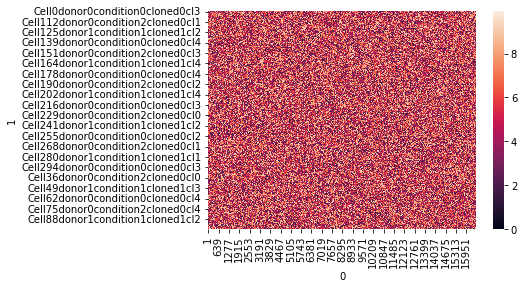

In [15]:
sns.heatmap(np.log2(all_coverage_df))

## Create variant-by-cell matrix for each variant 

In [25]:
ref_df.tail()

,pos,ref
16564_C,16564,C
16565_G,16565,G
16566_A,16566,A
16567_T,16567,T
16568_G,16568,G


In [26]:
all_nt_pileup[(0,'A')]

,0,1,2,3,4,5
0,2,Cell0donor0condition0cloned0cl3,266,37,245,37
1,5,Cell0donor0condition0cloned0cl3,8,37,8,37
2,7,Cell0donor0condition0cloned0cl3,7,37,9,37
3,13,Cell0donor0condition0cloned0cl3,62,37,66,37
4,16,Cell0donor0condition0cloned0cl3,2,37,2,37
...,...,...,...,...,...,...
3353725,16557,Cell9donor1condition0cloned1cl1,266,37,245,37
3353726,16559,Cell9donor1condition0cloned1cl1,70,37,57,37
3353727,16561,Cell9donor1condition0cloned1cl1,32,37,32,37
3353728,16564,Cell9donor1condition0cloned1cl1,2,37,2,37


## Calculate AF

In [32]:
pd.concat(all_nt_pileup).reset_index().rename({"level_0":"condition","level_1":"nt"}, axis=1).drop("level_2", axis=1)

,condition,nt,0,1,2,3,4,5
0,0,A,2,Cell0donor0condition0cloned0cl3,266,37,245,37
1,0,A,5,Cell0donor0condition0cloned0cl3,8,37,8,37
2,0,A,7,Cell0donor0condition0cloned0cl3,7,37,9,37
3,0,A,13,Cell0donor0condition0cloned0cl3,62,37,66,37
4,0,A,16,Cell0donor0condition0cloned0cl3,2,37,2,37
...,...,...,...,...,...,...,...,...
33441425,2,T,16551,Cell9donor1condition2cloned1cl1,14,37,18,37
33441426,2,T,16555,Cell9donor1condition2cloned1cl1,26,37,38,37
33441427,2,T,16562,Cell9donor1condition2cloned1cl1,13,37,3,37
33441428,2,T,16568,Cell9donor1condition2cloned1cl1,5,37,11,37


In [19]:
all_nt_df = pd.concat(all_nt_pileup).reset_index().rename({"level_0":"condition","level_1":"nt"}, axis=1).drop("level_2", axis=1)
all_nt_df["coverage"] = all_nt_df[2] + all_nt_df[4]
all_nt_df["af"] = all_nt_df.apply(lambda x: x["coverage"]/all_coverage_df.loc[x[1], x[0]]  ,axis=1)
all_nt_df["Variant"]  = all_nt_df.apply(lambda x: f"{x[0]}>{x['nt']}", axis=1)
all_nt_df = all_nt_df.pivot(index=1,columns="Variant", values="af")
all_nt_df = all_nt_df.fillna(0)
all_nt_df

1,Cell0donor0condition0cloned0cl3,Cell0donor0condition1cloned0cl4,Cell0donor0condition2cloned0cl2,Cell0donor1condition0cloned1cl2,Cell0donor1condition1cloned1cl1,Cell0donor1condition2cloned1cl3,Cell100donor0condition0cloned0cl3,Cell100donor0condition1cloned0cl2,Cell100donor0condition2cloned0cl2,Cell100donor1condition0cloned1cl3,...,Cell99donor0condition2cloned0cl1,Cell99donor1condition0cloned1cl2,Cell99donor1condition1cloned1cl3,Cell99donor1condition2cloned1cl0,Cell9donor0condition0cloned0cl4,Cell9donor0condition1cloned0cl4,Cell9donor0condition2cloned0cl0,Cell9donor1condition0cloned1cl1,Cell9donor1condition1cloned1cl4,Cell9donor1condition2cloned1cl1
Variant,,,,,,,,,,,,,,,,,,,,,
10000>A,0.000000,0.0,0.000000,0.001953,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
10000>C,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.001953
10000>G,1.000000,1.0,1.000000,0.998047,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,0.996094
10000>T,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.001953
10001>A,0.001953,0.0,0.000000,0.000000,0.003906,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.001953,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99>T,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000
9>A,0.000000,0.0,0.003906,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003906,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
9>C,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.001953,0.0,0.000000,0.0,0.0,0.001953,0.0,0.000000


In [29]:
all_nt_df.index.duplicated().sum()

0

In [30]:
all_nt_df

1,Cell0donor0condition0cloned0cl3,Cell0donor0condition1cloned0cl4,Cell0donor0condition2cloned0cl2,Cell0donor1condition0cloned1cl2,Cell0donor1condition1cloned1cl1,Cell0donor1condition2cloned1cl3,Cell100donor0condition0cloned0cl3,Cell100donor0condition1cloned0cl2,Cell100donor0condition2cloned0cl2,Cell100donor1condition0cloned1cl3,...,Cell99donor0condition2cloned0cl1,Cell99donor1condition0cloned1cl2,Cell99donor1condition1cloned1cl3,Cell99donor1condition2cloned1cl0,Cell9donor0condition0cloned0cl4,Cell9donor0condition1cloned0cl4,Cell9donor0condition2cloned0cl0,Cell9donor1condition0cloned1cl1,Cell9donor1condition1cloned1cl4,Cell9donor1condition2cloned1cl1
Variant,,,,,,,,,,,,,,,,,,,,,
10000>A,0.000000,0.0,0.000000,0.001953,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
10000>C,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.001953
10000>G,1.000000,1.0,1.000000,0.998047,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,0.996094
10000>T,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.001953
10001>A,0.001953,0.0,0.000000,0.000000,0.003906,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.000000,0.0,0.001953,0.0,0.0,0.000000,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99>T,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,1.0,...,1.0,1.000000,1.000000,1.0,1.000000,1.0,1.0,1.000000,1.0,1.000000
9>A,0.000000,0.0,0.003906,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.003906,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.000000
9>C,0.000000,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,...,0.0,0.000000,0.001953,0.0,0.000000,0.0,0.0,0.001953,0.0,0.000000


## Plot all variants (ref and alt)

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

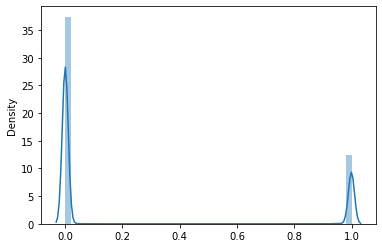

In [36]:
sns.distplot(all_nt_df.values.flatten())

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


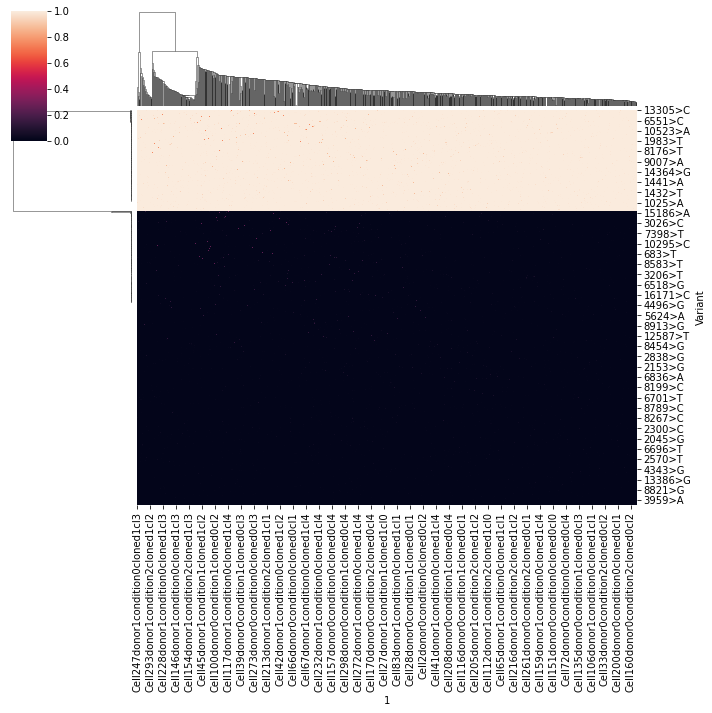

In [33]:
# sns.heatmap(all_nt_df.sample(1000,axis=0).sample(1000,axis=1))

## Plot variants from clones

In [39]:
clone_vars_df

,pos,ref,alt,ref_id,donor,clone,id
7369_C>G_d0cl1,7369,C,G,7369_C,0,d0cl1,7369>G
6842_T>G_d1cl2,6842,T,G,6842_T,1,d1cl2,6842>G
7151_C>G_d0cl2,7151,C,G,7151_C,0,d0cl2,7151>G


In [40]:
don_vars_df

,alt,ref,pos,donor,id
ref_id,,,,,
11719_G,A,G,11719,0,11719>A
14350_C,G,C,14350,0,14350>G
9528_C,G,C,9528,0,9528>G
12833_C,T,C,12833,0,12833>T
5767_C,T,C,5767,0,5767>T
12920_C,G,C,12920,0,12920>G
1558_A,G,A,1558,0,1558>G
11150_G,T,G,11150,0,11150>T
4832_C,A,C,4832,0,4832>A


In [37]:
clone_vars_df["id"] = clone_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
don_vars_df["id"] = don_vars_df.apply(lambda x: f"{x['pos']}>{x['alt']}", axis=1)
vars_of_interest = pd.concat([clone_vars_df.set_index("id"),don_vars_df.set_index("id")], axis=0)
vars_of_interest = vars_of_interest[["donor", "clone"]]
vars_of_interest

,donor,clone
id,,
7369>G,0,d0cl1
6842>G,1,d1cl2
7151>G,0,d0cl2
11719>A,0,NaN
14350>G,0,NaN
9528>G,0,NaN
12833>T,0,NaN
5767>T,0,NaN
12920>G,0,NaN


/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


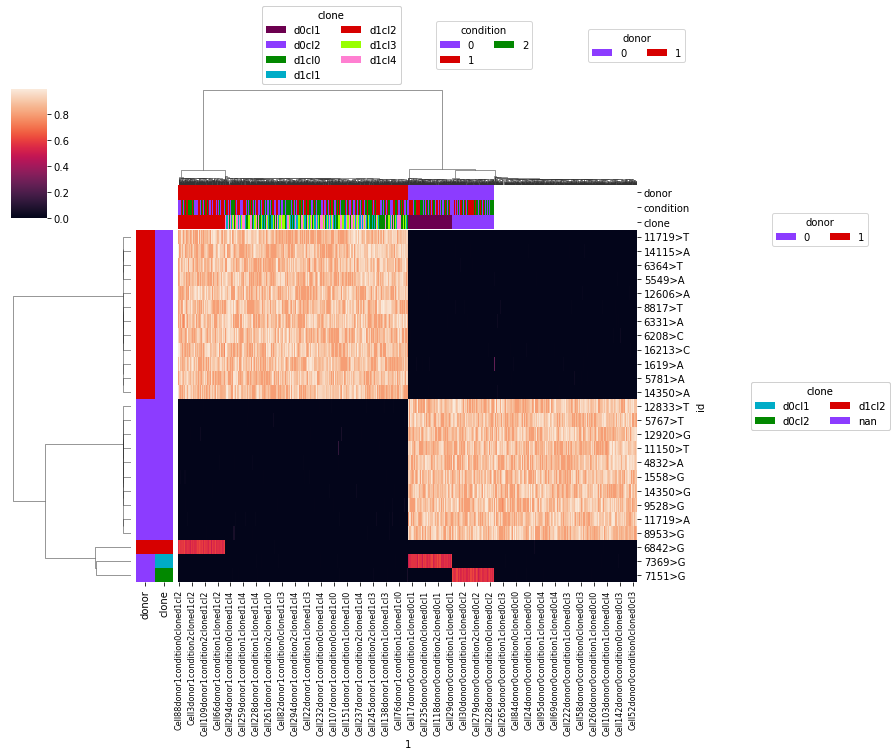

In [23]:
ch.plot_cluster(all_nt_df.loc[vars_of_interest.index],row_meta=vars_of_interest.astype(str),
                col_meta = all_cells_df.astype(str))
#plt.savefig(join(curr_outdir, "af.png"))

/home/isaac/miniconda3/envs/mttrace/lib/python3.7/site-packages/seaborn/matrix.py:654: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


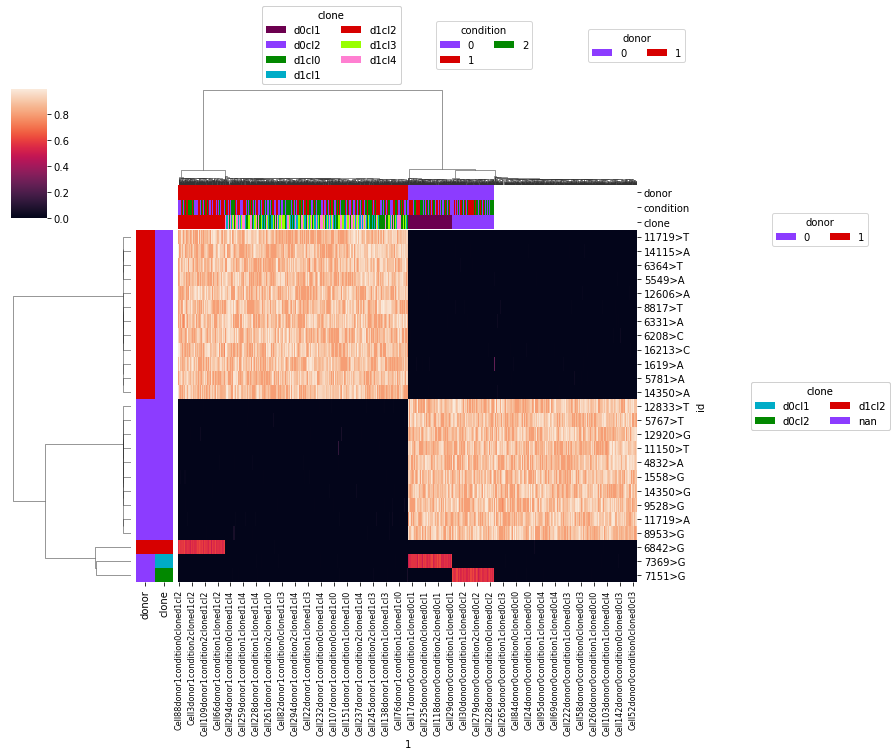

In [23]:
ch.plot_cluster(all_nt_df.loc[vars_of_interest.index],row_meta=vars_of_interest.astype(str),
                col_meta = all_cells_df.astype(str))
#plt.savefig(join(curr_outdir, "af.png"))